# Granger Causality Analysis: Sentiment and Stock Returns

This notebook demonstrates Granger causality testing to explore whether sentiment "causes" (predicts) stock returns, or vice versa.



## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
import kagglehub
from afinn import Afinn

c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download Financial News Dataset

We'll use a Kaggle dataset containing S&P 500 price data with financial news headlines (2008-2024).

In [2]:
# Download dataset from Kaggle
path = kagglehub.dataset_download("dyutidasmahaptra/s-and-p-500-with-financial-news-headlines-20082024")
print("Path to dataset files:", path)

# Load the dataset
import os
files = os.listdir(path)
print("\nAvailable files:", files)

# Load the main dataset (adjust filename if needed)
df_raw = pd.read_csv(os.path.join(path, files[0]))
print(f"\nDataset shape: {df_raw.shape}")
print("\nFirst few rows:")
print(df_raw.head())
print("\nColumn names:")
print(df_raw.columns.tolist())

100%|██████████| 498k/498k [00:00<00:00, 1.27MB/s]

Extracting files...
Path to dataset files: C:\Users\christian-vs\.cache\kagglehub\datasets\dyutidasmahaptra\s-and-p-500-with-financial-news-headlines-20082024\versions\1

Available files: ['sp500_headlines_2008_2024.csv']

Dataset shape: (19127, 3)

First few rows:
                                               Title        Date       CP
0   JPMorgan Predicts 2008 Will Be "Nothing But Net"  2008-01-02  1447.16
1  Dow Tallies Biggest First-session-of-year Poin...  2008-01-02  1447.16
2                   2008 predictions for the S&P 500  2008-01-02  1447.16
3  U.S. Stocks Higher After Economic Data, Monsan...  2008-01-03  1447.16
4  U.S. Stocks Climb As Hopes Increase For More F...  2008-01-07  1416.18

Column names:
['Title', 'Date', 'CP']
Path to dataset files: C:\Users\christian-vs\.cache\kagglehub\datasets\dyutidasmahaptra\s-and-p-500-with-financial-news-headlines-20082024\versions\1

Available files: ['sp500_headlines_2008_2024.csv']

Dataset shape: (19127, 3)

First few rows:
     

## Initialize AFINN Sentiment Analyzer

AFINN is a simple but effective lexicon-based sentiment analyzer that scores words from -5 (negative) to +5 (positive).

In [3]:
# Initialize AFINN sentiment analyzer
afinn = Afinn()
print("✓ AFINN sentiment analyzer ready")

✓ AFINN sentiment analyzer ready


## Process News Headlines with AFINN

Extract sentiment scores from financial news headlines using AFINN lexicon.

In [7]:
date_col = "Date"
headline_col = "Title"

# Convert date to datetime
df_raw[date_col] = pd.to_datetime(df_raw[date_col])

# Sort by date
df_raw = df_raw.sort_values(date_col).reset_index(drop=True)

print(f"\nDate range: {df_raw[date_col].min()} to {df_raw[date_col].max()}")
print(f"Total headlines: {len(df_raw)}")
print(f"\nSample headline: {df_raw[headline_col].iloc[0][:100]}...")


Date range: 2008-01-02 00:00:00 to 2024-03-04 00:00:00
Total headlines: 19127

Sample headline: JPMorgan Predicts 2008 Will Be "Nothing But Net"...


In [8]:
# Apply AFINN sentiment analysis
print("Analyzing sentiment with AFINN...")

def get_sentiment_score(text):
    """Get AFINN sentiment score for text"""
    if pd.isna(text) or text == "":
        return 0
    try:
        return afinn.score(str(text))
    except:
        return 0

# Process all headlines (AFINN is fast, no need to limit)
df_raw['sentiment_score'] = df_raw[headline_col].apply(get_sentiment_score)

print("\nSentiment analysis complete!")
print(f"Total headlines processed: {len(df_raw)}")
print(f"Mean sentiment: {df_raw['sentiment_score'].mean():.4f}")
print(f"Std sentiment: {df_raw['sentiment_score'].std():.4f}")
print(f"Min sentiment: {df_raw['sentiment_score'].min():.1f}")
print(f"Max sentiment: {df_raw['sentiment_score'].max():.1f}")

Analyzing sentiment with AFINN...

Sentiment analysis complete!
Total headlines processed: 19127
Mean sentiment: 0.1751
Std sentiment: 1.8026
Min sentiment: -14.0
Max sentiment: 11.0

Sentiment analysis complete!
Total headlines processed: 19127
Mean sentiment: 0.1751
Std sentiment: 1.8026
Min sentiment: -14.0
Max sentiment: 11.0


## Aggregate Sentiment by Date

Combine multiple headlines per day into a single sentiment measure.

In [9]:
# Aggregate sentiment by date (mean of daily headlines)
daily_sentiment = df_raw.groupby(date_col)['sentiment_score'].mean().reset_index()
daily_sentiment.columns = ['Date', 'H']  # H for sentiment

print(f"Daily sentiment data shape: {daily_sentiment.shape}")
print("\nSample daily sentiment:")
print(daily_sentiment.head(10))

Daily sentiment data shape: (3507, 2)

Sample daily sentiment:
        Date         H
0 2008-01-02 -0.333333
1 2008-01-03  0.000000
2 2008-01-07  3.000000
3 2008-01-09  1.000000
4 2008-01-10  0.000000
5 2008-01-22  0.000000
6 2008-01-29 -2.000000
7 2008-01-30  3.000000
8 2008-02-01  0.000000
9 2008-02-05 -1.333333


## Get S&P 500 Returns Data

Match returns with sentiment data for the same time period.

In [11]:
import yfinance as yf

# Get date range from sentiment data
start_date = daily_sentiment['Date'].min()
end_date = daily_sentiment['Date'].max()

print(f"Downloading SPY data from {start_date} to {end_date}...")

# Download SPY data
spy = yf.download("SPY", start=start_date, end=end_date)

# Calculate daily log returns
spy['R'] = np.log(spy['Close'] / spy['Close'].shift(1))

# Create returns dataframe
returns_df = spy[['R']].reset_index()
returns_df.columns = ['Date', 'R']
returns_df = returns_df.dropna()

print(f"\nReturns data shape: {returns_df.shape}")
print("\nSample returns:")
print(returns_df.head(10))

C:\Users\christian-vs\AppData\Local\Temp\1\ipykernel_49416\2338572677.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download("SPY", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Returns data shape: (4068, 2)

Sample returns:
         Date         R
1  2008-01-03 -0.000483
2  2008-01-04 -0.024812
3  2008-01-07 -0.000850
4  2008-01-08 -0.016280
5  2008-01-09  0.010455
6  2008-01-10  0.006533
7  2008-01-11 -0.008101
8  2008-01-14  0.008030
9  2008-01-15 -0.022259
10 2008-01-16 -0.008650


## Merge Sentiment and Returns

Combine sentiment and returns data on matching dates.

In [12]:
# Merge sentiment and returns on date
df = pd.merge(returns_df, daily_sentiment, on='Date', how='inner')

# Sort by date
df = df.sort_values('Date').reset_index(drop=True)

# Drop any missing values
df = df.dropna()

print(f"Merged data shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print("\nData summary:")
print(df.describe())
print("\nFirst few rows:")
print(df.head())
print("\nLast few rows:")
print(df.tail())

Merged data shape: (3505, 3)
Date range: 2008-01-03 00:00:00 to 2024-03-01 00:00:00

Data summary:
                                Date            R            H
count                           3505  3505.000000  3505.000000
mean   2016-12-05 08:49:34.493580544     0.000373     0.150058
min              2008-01-03 00:00:00    -0.115887    -8.000000
25%              2013-05-17 00:00:00    -0.004001    -0.333333
50%              2017-01-05 00:00:00     0.000658     0.000000
75%              2020-08-24 00:00:00     0.005908     0.727273
max              2024-03-01 00:00:00     0.135577     8.000000
std                              NaN     0.012192     1.130083

First few rows:
        Date         R    H
0 2008-01-03 -0.000483  0.0
1 2008-01-07 -0.000850  3.0
2 2008-01-09  0.010455  1.0
3 2008-01-10  0.006533  0.0
4 2008-01-22 -0.010199  0.0

Last few rows:
           Date         R         H
3500 2024-02-26 -0.003669  0.000000
3501 2024-02-27  0.001856  0.000000
3502 2024-02-28 -0.001322

## Visualize Returns and AFINN Sentiment

Let's plot both time series to see how they relate to each other.

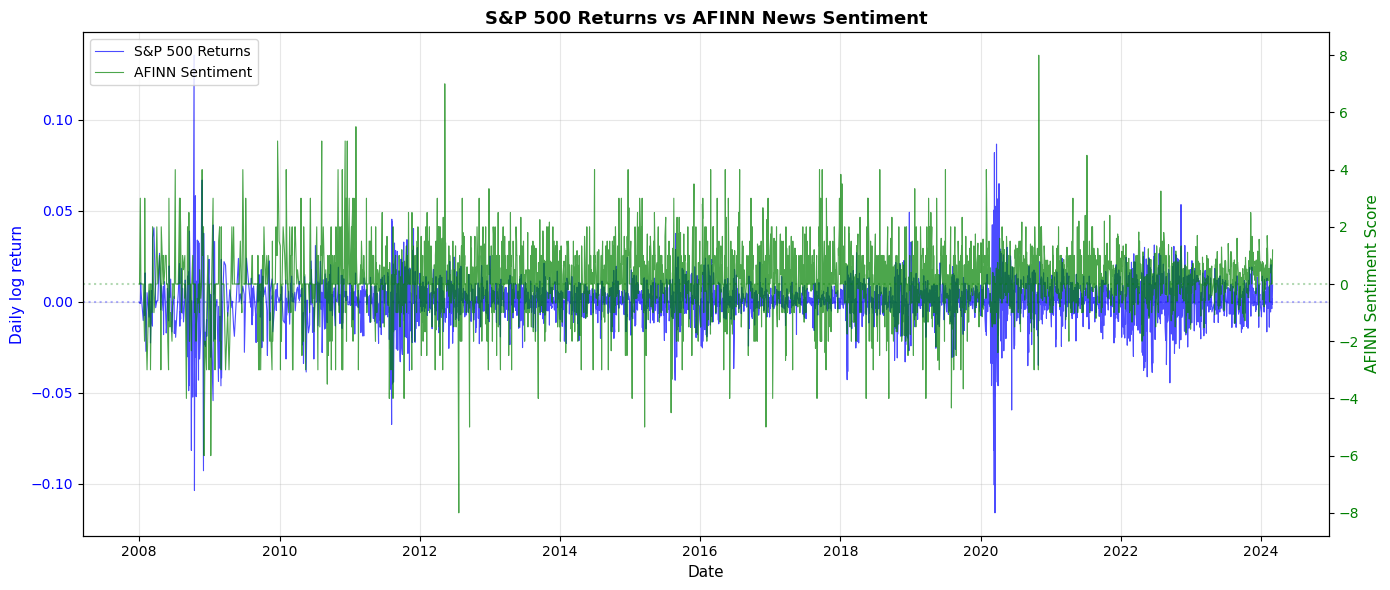

In [13]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot returns on left axis
ax1.plot(df['Date'], df['R'], label='S&P 500 Returns', linewidth=0.8, color='blue', alpha=0.7)
ax1.set_ylabel('Daily log return', color='blue', fontsize=11)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel('Date', fontsize=11)
ax1.axhline(y=0, color='blue', linestyle=':', alpha=0.3)

# Plot AFINN sentiment on right axis
ax2 = ax1.twinx()
ax2.plot(df['Date'], df['H'], label='AFINN Sentiment', linewidth=0.8, 
         linestyle='-', color='green', alpha=0.7)
ax2.set_ylabel('AFINN Sentiment Score', color='green', fontsize=11)
ax2.tick_params(axis='y', labelcolor='green')
ax2.axhline(y=0, color='green', linestyle=':', alpha=0.3)

ax1.set_title('S&P 500 Returns vs AFINN News Sentiment', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

fig.tight_layout()
plt.show()

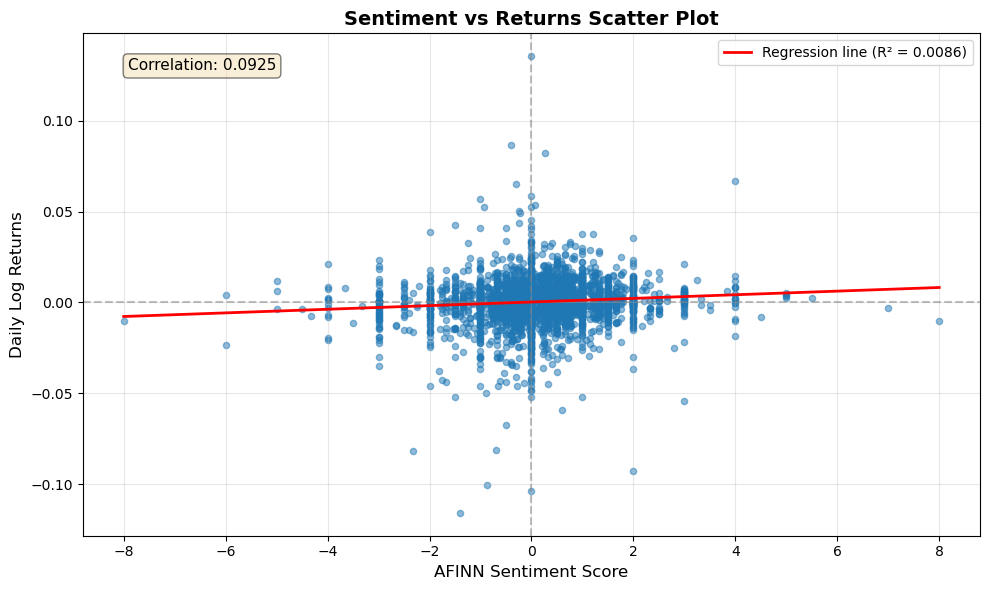

In [15]:
from scipy.stats import linregress

# Scatterplot of sentiment and returns
plt.figure(figsize=(10, 6))
plt.scatter(df['H'], df['R'], alpha=0.5, s=20)
plt.xlabel('AFINN Sentiment Score', fontsize=12)
plt.ylabel('Daily Log Returns', fontsize=12)
plt.title('Sentiment vs Returns Scatter Plot', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)

# Add correlation coefficient
correlation = df[['H', 'R']].corr().iloc[0, 1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.4f}', 
         transform=plt.gca().transAxes, fontsize=11,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
# Add linear regression line
slope, intercept, r_value, p_value, std_err = linregress(df['H'], df['R'])
x_line = np.array([df['H'].min(), df['H'].max()])
y_line = slope * x_line + intercept
plt.plot(x_line, y_line, 'r-', linewidth=2, label=f'Regression line (R² = {r_value**2:.4f})')
plt.legend()

plt.show()

## Granger Causality Tests

Granger causality tests whether past values of one time series help predict another time series.

**Null Hypothesis (H₀):** X does NOT Granger-cause Y (past values of X don't help predict Y)

**Interpretation:**
- If p-value < 0.05: Reject H₀ → X Granger-causes Y (X helps predict Y)
- If p-value ≥ 0.05: Fail to reject H₀ → X does NOT Granger-cause Y

**Important:** Granger causality ≠ true causation! It only tests predictive power.

### Test 1: Does Sentiment Granger-Cause Returns? (H → R)

In [16]:
# Test: Does sentiment H help predict returns R?
# Order matters: [dependent_variable, independent_variable]
# Here: [R, H] tests if H Granger-causes R

print("="*70)
print("TEST 1: Does sentiment H Granger-cause returns R?")
print("="*70)
print("H₀: Past sentiment does NOT help predict returns")
print("If p < 0.05: Sentiment has predictive power for returns\n")

gc_test_1 = grangercausalitytests(df[["R", "H"]], maxlag=3, verbose=True)

TEST 1: Does sentiment H Granger-cause returns R?
H₀: Past sentiment does NOT help predict returns
If p < 0.05: Sentiment has predictive power for returns


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.1595  , p=0.0025  , df_denom=3501, df_num=1
ssr based chi2 test:   chi2=9.1673  , p=0.0025  , df=1
likelihood ratio test: chi2=9.1553  , p=0.0025  , df=1
parameter F test:         F=9.1595  , p=0.0025  , df_denom=3501, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.3962  , p=0.0124  , df_denom=3498, df_num=2
ssr based chi2 test:   chi2=8.8050  , p=0.0122  , df=2
likelihood ratio test: chi2=8.7939  , p=0.0123  , df=2
parameter F test:         F=4.3962  , p=0.0124  , df_denom=3498, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.1595  , p=0.0237  , df_denom=3495, df_num=3
ssr based chi2 test:   chi2=9.4976  , p=0.0234  , df=3
likelihood ratio test: chi2=9.4848  , p=0.0235  , df=3
parame

c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


### Test 2: Do Returns Granger-Cause Sentiment? (R → H)

In [17]:
# Test: Do returns R help predict sentiment H?
# Order: [H, R] tests if R Granger-causes H

print("="*70)
print("TEST 2: Do returns R Granger-cause sentiment H?")
print("="*70)
print("H₀: Past returns do NOT help predict sentiment")
print("If p < 0.05: Returns have predictive power for sentiment\n")

gc_test_2 = grangercausalitytests(df[["H", "R"]], maxlag=3, verbose=True)

TEST 2: Do returns R Granger-cause sentiment H?
H₀: Past returns do NOT help predict sentiment
If p < 0.05: Returns have predictive power for sentiment


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.2685  , p=0.0071  , df_denom=3501, df_num=1
ssr based chi2 test:   chi2=7.2747  , p=0.0070  , df=1
likelihood ratio test: chi2=7.2672  , p=0.0070  , df=1
parameter F test:         F=7.2685  , p=0.0071  , df_denom=3501, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.8808  , p=0.0076  , df_denom=3498, df_num=2
ssr based chi2 test:   chi2=9.7755  , p=0.0075  , df=2
likelihood ratio test: chi2=9.7618  , p=0.0076  , df=2
parameter F test:         F=4.8808  , p=0.0076  , df_denom=3498, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.0697  , p=0.0017  , df_denom=3495, df_num=3
ssr based chi2 test:   chi2=15.2395 , p=0.0016  , df=3
likelihood ratio test: chi2=15.2064 , p=0.0016  , df=3
parameter

c:\ProgramData\anaconda3\envs\sentimentF25\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
